In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pathlib
import cv2
from glob import glob
import os

In [2]:
# Mount Google Drive (only needed in Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def process(data):
    path = pathlib.Path(data)
    filepaths = list(path.glob(r"*/*.jpg"))  # Mengambil semua file jpg
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))  # Mengambil label dari path
    df1 = pd.Series(filepaths, name='filepaths').astype(str)  # Konversi filepaths menjadi Series
    df2 = pd.Series(labels, name='labels')  # Konversi labels menjadi Series
    df = pd.concat([df1, df2], axis=1)  # Gabungkan menjadi DataFrame
    return df

# Ganti dengan path direktori dataset Anda
train_dir = '/content/drive/MyDrive/Bangkit 2024 Capstone/Machine learning/Foto/train'  # Direktori data pelatihan
valid_dir = '/content/drive/MyDrive/Bangkit 2024 Capstone/Machine learning/Foto/valid'  # Direktori data validasi

# Mengolah data pelatihan dan validasi
df_train = process(train_dir)
df_valid = process(valid_dir)

# Menampilkan DataFrame untuk data pelatihan dan validasi
print("Data Pelatihan:")
print(df_train.head())

print("\nData Validasi:")
print(df_valid.head())


Data Pelatihan:
                                           filepaths    labels
0  /content/drive/MyDrive/Bangkit 2024 Capstone/M...  PETE (1)
1  /content/drive/MyDrive/Bangkit 2024 Capstone/M...  PETE (1)
2  /content/drive/MyDrive/Bangkit 2024 Capstone/M...  PETE (1)
3  /content/drive/MyDrive/Bangkit 2024 Capstone/M...  PETE (1)
4  /content/drive/MyDrive/Bangkit 2024 Capstone/M...  PETE (1)

Data Validasi:
                                           filepaths    labels
0  /content/drive/MyDrive/Bangkit 2024 Capstone/M...  HDPE (2)
1  /content/drive/MyDrive/Bangkit 2024 Capstone/M...  HDPE (2)
2  /content/drive/MyDrive/Bangkit 2024 Capstone/M...  HDPE (2)
3  /content/drive/MyDrive/Bangkit 2024 Capstone/M...  HDPE (2)
4  /content/drive/MyDrive/Bangkit 2024 Capstone/M...  HDPE (2)


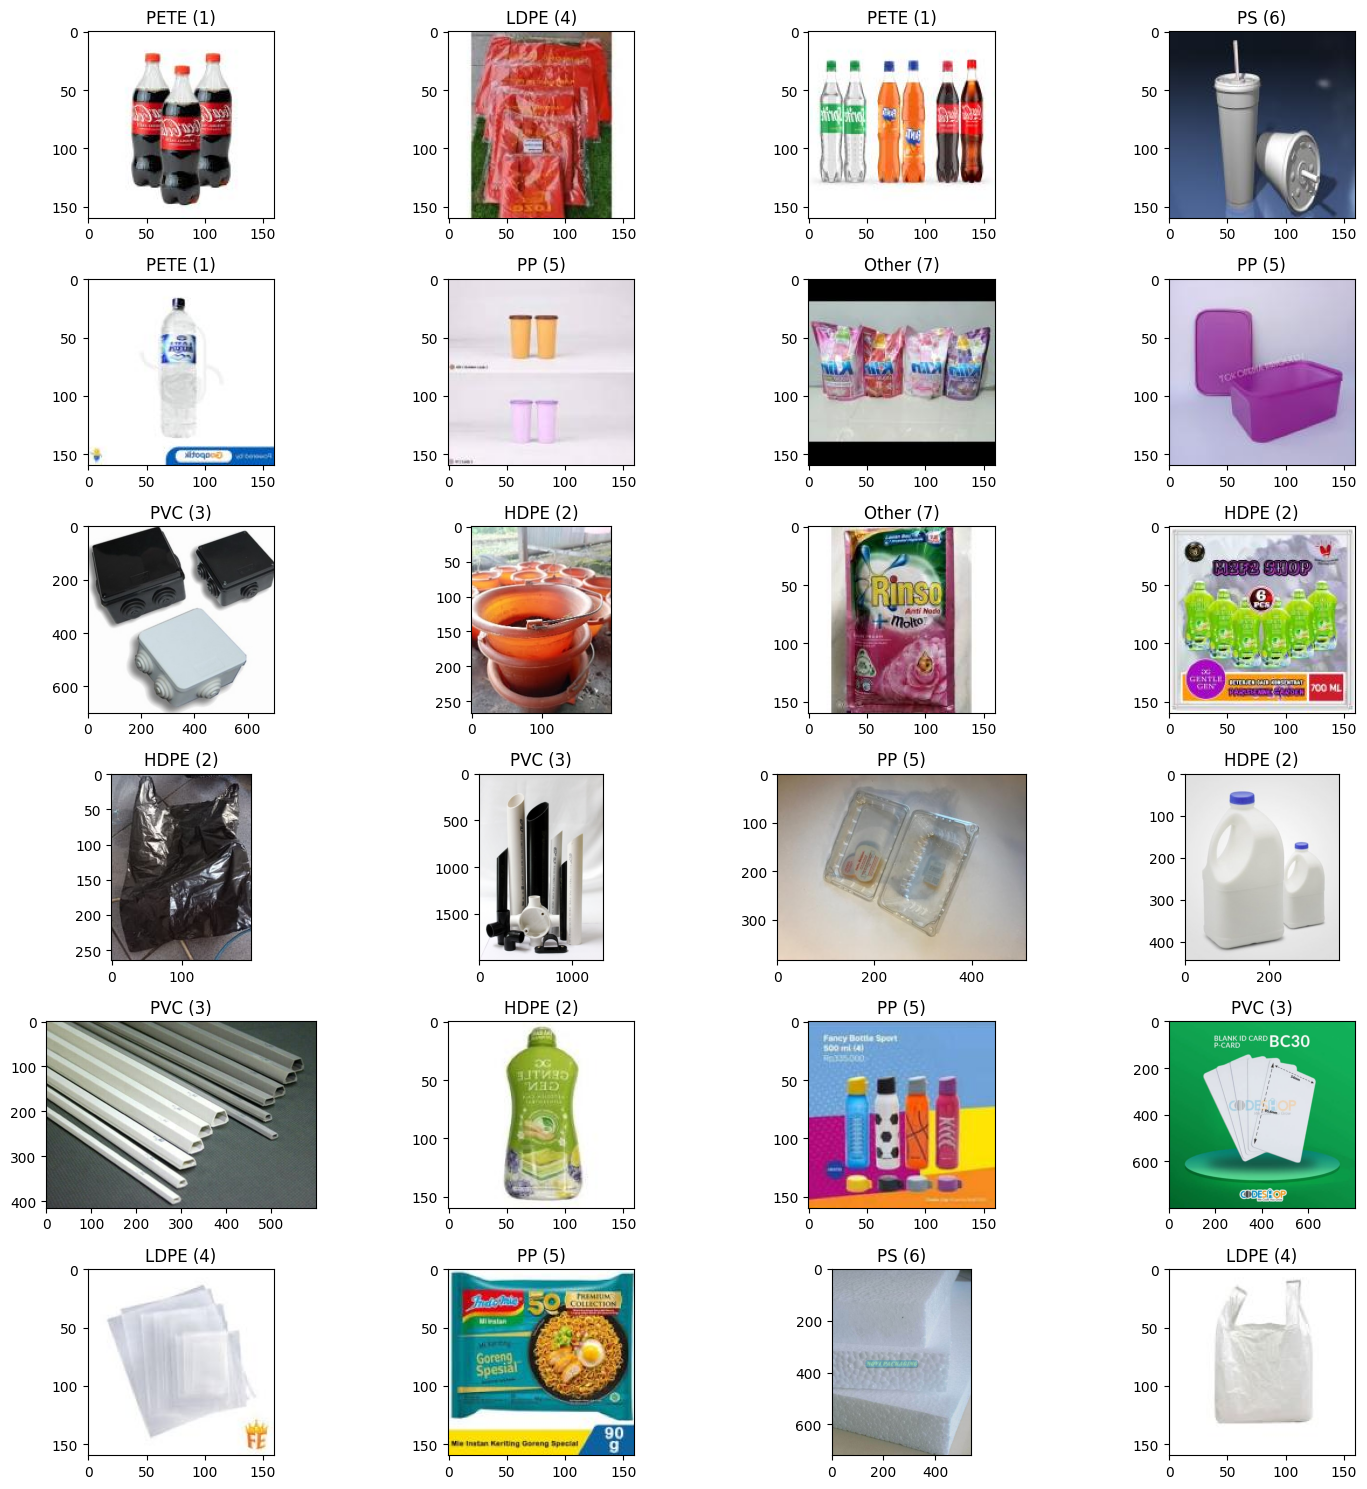

In [4]:
# Shuffle the training data
df_train = df_train.sample(frac=1).reset_index(drop=True)
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    x = plt.imread(df_train['filepaths'][i])
    ax.imshow(x)
    ax.set_title(df_train['labels'][i])
plt.tight_layout()
plt.show()

In [5]:
# Import library yang dibutuhkan
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# Memuat MobileNetV2 tanpa lapisan atas
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Membekukan semua lapisan MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

# Mengambil output dari lapisan terakhir
last_output = base_model.output

# Menambahkan lapisan baru untuk klasifikasi
x = Flatten()(last_output)  # Mengubah output dari MobileNetV2 menjadi satu dimensi
x = Dense(128, activation='relu')(x)  # Lapisan fully connected
x = BatchNormalization()(x)           # Menambahkan Batch Normalization (opsional)
x = Dropout(0.5)(x)                   # Lapisan dropout untuk regularisasi
output = Dense(7, activation='softmax')(x)  # Output untuk 7 kelas

# Membuat model lengkap
model = Model(inputs=base_model.input, outputs=output)

# Mengompilasi model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  # Untuk klasifikasi multi-kelas
              metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 4,880,967 (18.62 MB)

 Trainable params: 2,622,727 (10.00 MB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [6]:
# Mendefinisikan direktori untuk pelatihan dan validasi
train_dir = '/content/drive/MyDrive/Bangkit 2024 Capstone/Machine learning/Foto/train'  # Jalur ke direktori data pelatihan
val_dir = '/content/drive/MyDrive/Bangkit 2024 Capstone/Machine learning/Foto/valid'  # Jalur ke direktori data validasi

# Mengatur ImageDataGenerator untuk pelatihan dengan augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255)  # Normalisasi nilai piksel untuk validasi

# Membuat generator untuk data pelatihan
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Sesuaikan dengan input model
    batch_size=32,
    class_mode='categorical'  # Menggunakan categorical untuk multi-kelas
)

# Membuat generator untuk data validasi
test_set = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),  # Sesuaikan dengan input model
    batch_size=32,
    class_mode='categorical'  # Menggunakan categorical untuk multi-kelas
)


Found 2950 images belonging to 7 classes.
Found 775 images belonging to 7 classes.


In [7]:
#import tensorflow as tf
#import numpy as np

class MyCustomDataset(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size, **kwargs):
        super(MyCustomDataset, self).__init__(**kwargs)  # Memanggil konstruktor superclass dengan kwargs
        self.data = data
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_data, batch_labels

# Contoh penggunaan MyCustomDataset
data = np.random.rand(100, 224, 224, 3)  # Contoh data gambar
labels = np.random.randint(0, 7, (100,))  # Contoh label untuk 7 kelas
batch_size = 32

# Inisialisasi dataset
dataset = MyCustomDataset(data=data, labels=labels, batch_size=batch_size)

# Mendefinisikan MyDataset sebagai subkelas tf.data.Dataset
class MyDataset(tf.data.Dataset):
    def _generator(data, labels):
        def generator():
            for i in range(len(data)):
                yield data[i], labels[i]
        return generator

    def __new__(cls, data, labels, **kwargs):
        return tf.data.Dataset.from_generator(
            cls._generator(data, labels),
            output_signature=(
                tf.TensorSpec(shape=data.shape[1:], dtype=tf.float32),
                tf.TensorSpec(shape=labels.shape[1:], dtype=tf.int32)
            )
        )


In [8]:
# Callback untuk menyimpan bobot terbaik berdasarkan akurasi validasi
callback_cp = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Bangkit 2024 Capstone/Machine learning/best-weight/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.keras",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="max"
)

callback_es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Memantau 'val_loss'
    restore_best_weights=True,
    patience=20
)

# Freeze the layers of MobileNet
for layer in base_model.layers:
    layer.trainable = False

# Get the output of the last layer
last_output = base_model.output

# Add new layers for classification
x = Flatten()(last_output)  # Flatten the output from MobileNet
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout layer for regularization
output = Dense(7, activation='softmax')(x)  # Adjusted for 7 classes

# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model
history = model.fit(
    train_set,
    epochs=30,
    validation_data=test_set,
    verbose=2,
    callbacks=[callback_es, callback_cp]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.55484, saving model to /content/drive/MyDrive/Bangkit 2024 Capstone/Machine learning/best-weight/weights-improvement-01-0.55.keras
93/93 - 87s - 940ms/step - accuracy: 0.3990 - loss: 1.7004 - val_accuracy: 0.5548 - val_loss: 1.2698
Epoch 2/30

Epoch 2: val_accuracy improved from 0.55484 to 0.64129, saving model to /content/drive/MyDrive/Bangkit 2024 Capstone/Machine learning/best-weight/weights-improvement-02-0.64.keras
93/93 - 86s - 921ms/step - accuracy: 0.5519 - loss: 1.2271 - val_accuracy: 0.6413 - val_loss: 1.0620
Epoch 3/30

Epoch 3: val_accuracy improved from 0.64129 to 0.64258, saving model to /content/drive/MyDrive/Bangkit 2024 Capstone/Machine learning/best-weight/weights-improvement-03-0.64.keras
93/93 - 78s - 843ms/step - accuracy: 0.6129 - loss: 1.0856 - val_accuracy: 0.6426 - val_loss: 1.0207
Epoch 4/30

Epoch 4: val_accuracy improved from 0.64258 to 0.67355, saving model to /content/drive/MyDrive/Bangkit 2024 Capstone/Machin

Training Accuracy: 0.8641
Validation Accuracy: 0.7987
Training Loss: 0.4005
Validation Loss: 0.6137


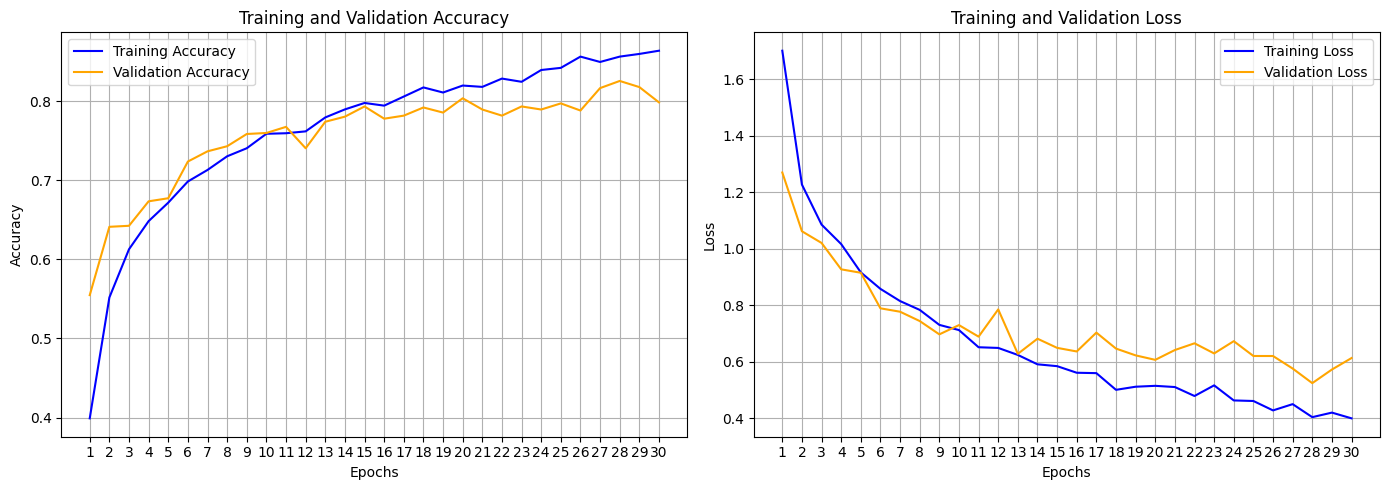

In [9]:
# Mengambil akurasi dan loss dari riwayat pelatihan
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)  # Mulai dari 1 untuk menyesuaikan dengan jumlah epoch

# Menampilkan informasi akurasi dan loss
print(f'Training Accuracy: {train_accuracy[-1]:.4f}')
print(f'Validation Accuracy: {val_accuracy[-1]:.4f}')
print(f'Training Loss: {train_loss[-1]:.4f}')
print(f'Validation Loss: {val_loss[-1]:.4f}')

# Membuat plot untuk akurasi
plt.figure(figsize=(14, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.grid()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid()

# Menampilkan grafik
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


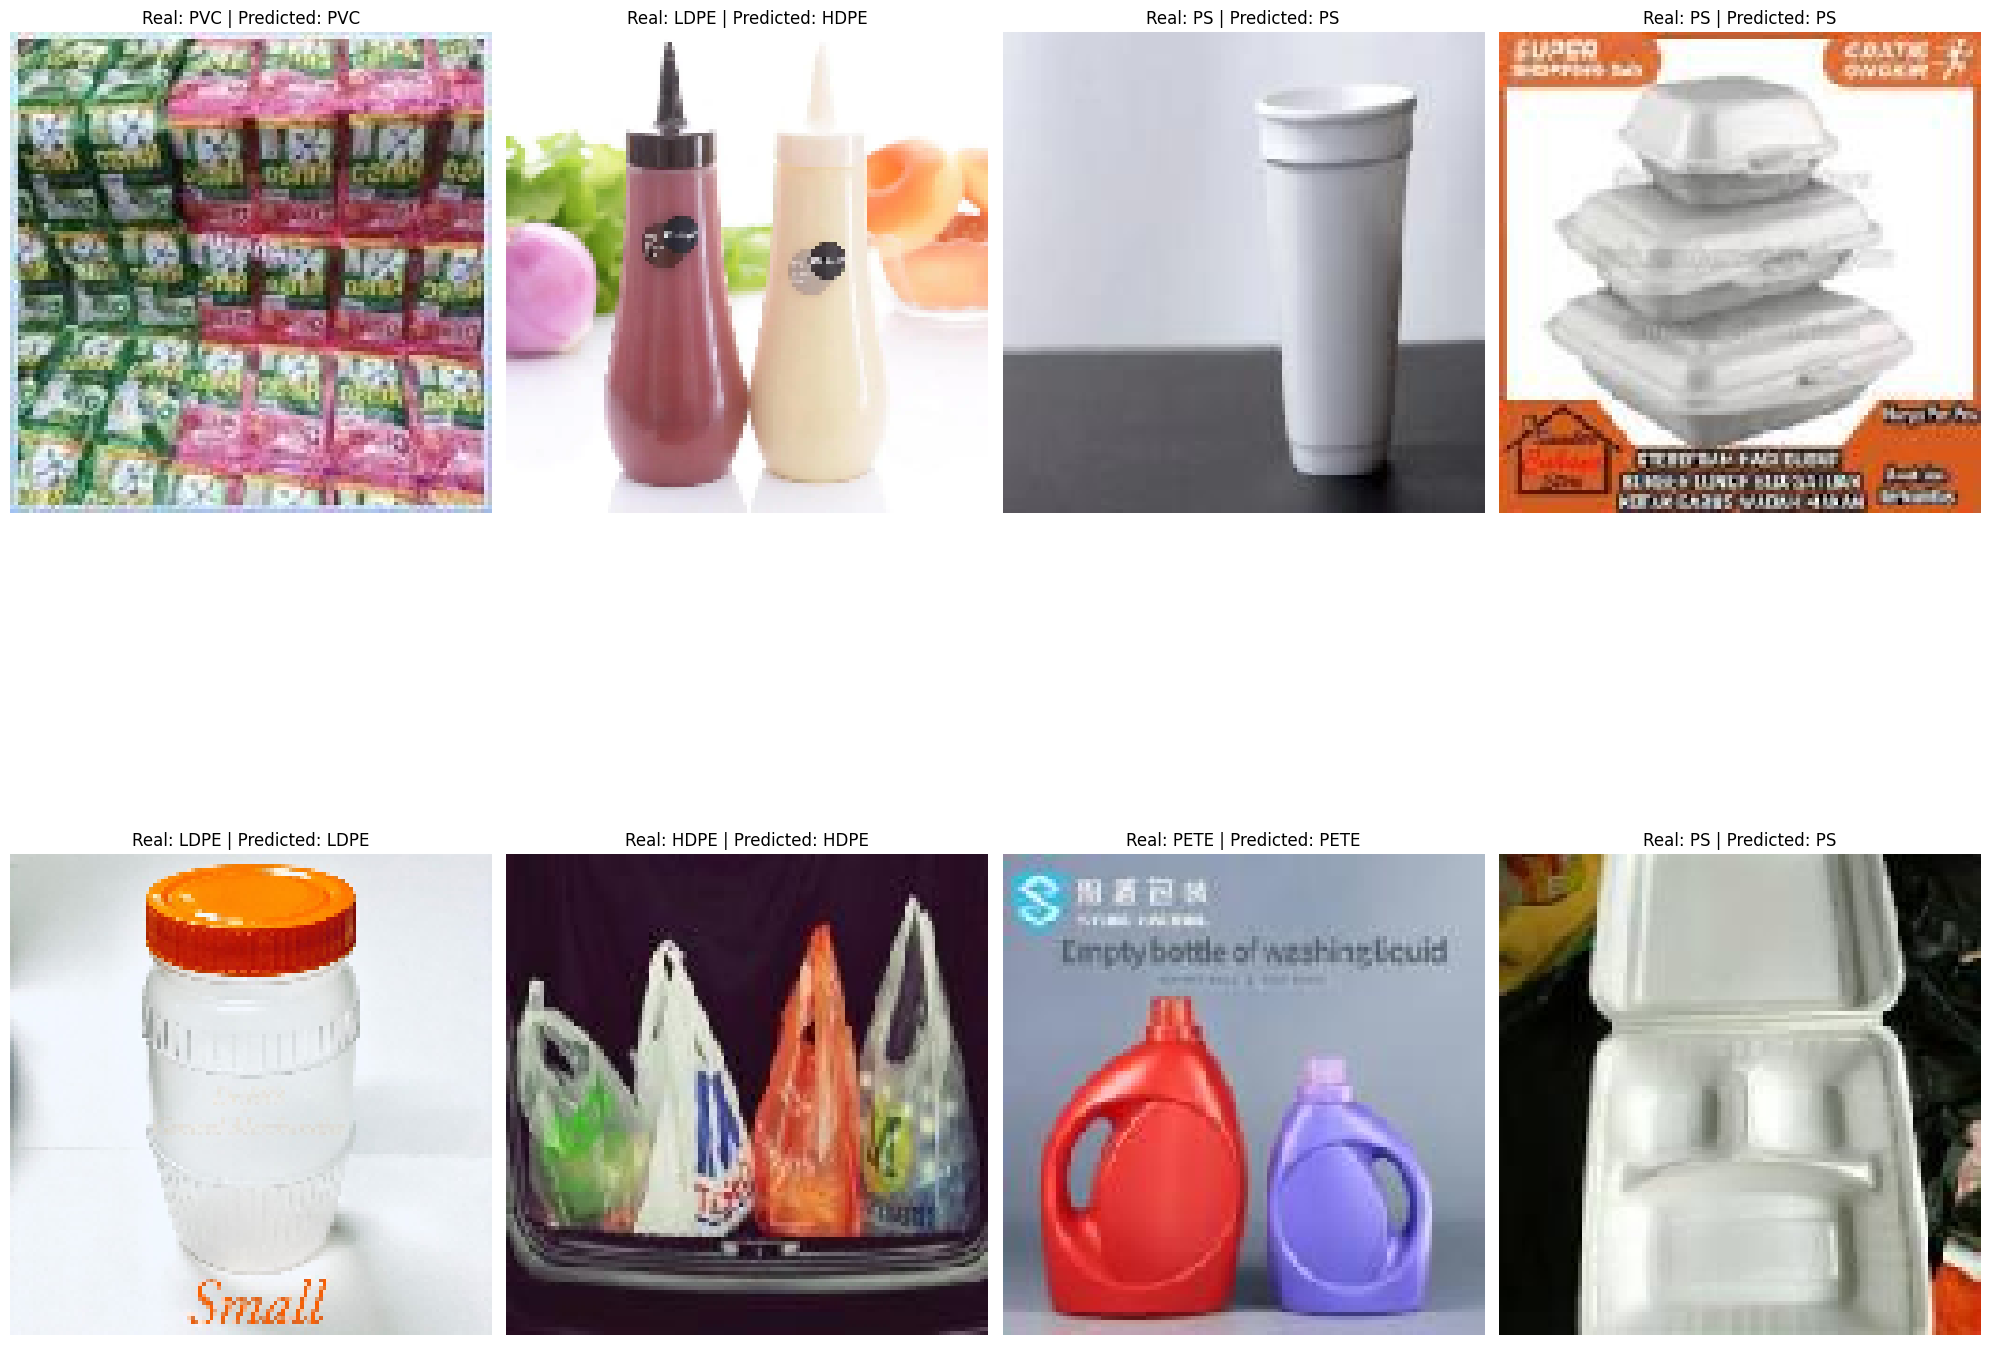

In [10]:
# Definisikan class names sesuai dengan label yang digunakan
class_names = ['PETE', 'HDPE', 'PVC', 'LDPE', 'PP', 'PS', 'Other']  # Ganti dengan nama kelas yang sesuai

# Mengambil batch gambar dan label dari test_set
images, labels = next(iter(test_set))

# Melakukan prediksi pada gambar
preds = model.predict(images)

# Mengatur subplots (2 baris, 4 kolom) untuk menampilkan 8 gambar
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 20))
axis_dict = {i: ax for i, ax in enumerate(axes.flat)}

# Looping melalui 8 gambar pertama
for i in range(8):
    actual_label_idx = np.argmax(labels[i])  # Indeks label sebenarnya
    predicted_label_idx = np.argmax(preds[i])

    # Menampilkan gambar
    axis_dict[i].imshow(images[i])

    # Menambahkan judul dengan label sebenarnya dan prediksi
    axis_dict[i].set_title(
        f"Real: {class_names[actual_label_idx]} | Predicted: {class_names[predicted_label_idx]}",
        fontsize=12
    )
    axis_dict[i].axis('off')  # Menyembunyikan sumbu untuk tampilan yang lebih bersih

# Mengatur tata letak
plt.tight_layout()
plt.show()

In [11]:
# Menentukan direktori model di Google Drive
model_dir = '/content/drive/MyDrive/Bangkit 2024 Capstone/Machine learning/'  # Sesuaikan dengan path Anda
model_name = "model_v2"
model_path = os.path.join(model_dir, f"{model_name}.keras")  # Menggunakan ekstensi .keras

# Memastikan direktori penyimpanan ada
if not os.path.exists(model_dir):
    try:
        os.makedirs(model_dir)  # Menggunakan makedirs untuk membuat direktori beserta subdirektorinya jika diperlukan
        print(f"Direktori '{model_dir}' berhasil dibuat.")
    except OSError as e:
        print(f"Gagal membuat direktori. Alasan: {e}")
else:
    print(f"Direktori '{model_dir}' sudah ada.")

# Mencoba menyimpan model dalam format .keras
try:
    model.save(model_path)
    print(f"Model berhasil disimpan di: {model_path}")
except Exception as e:
    print(f"Gagal menyimpan model. Alasan: {e}")

Direktori '/content/drive/MyDrive/Bangkit 2024 Capstone/Machine learning/' sudah ada.
Model berhasil disimpan di: /content/drive/MyDrive/Bangkit 2024 Capstone/Machine learning/model_v2.keras
